# Tomography and data augmentation

## generating data

In [ ]:
import os
import multiprocessing
multiprocessing.set_start_method('fork')
from multiprocessing import Pool
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage, datasets, interpolate
import scipy as sp
import tqdm

from utils.image import *
from utils.radon_transformation import *

NameError: name 'multiprocessing' is not defined

In [ ]:
tomo_cfg = TomographyConfig(
    angle_arr=np.arange(-70, 70, 4),
)

# Shape generation parameters
shape_cfg = ShapeConfig(
    dim0=128,
    dim1=128,
    margin=5,
    min_rad=3,
    max_rad=25,
    min_area=5000,
    max_area=11000,
    continue_prob=0.9,
)

# Atomic structure parameters
atom_cfg = AtomConfig(
    pixel_size=0.4,
    target_density_dist=2.5,
    target_fill_ratio=0.90,
    patch_radius=3,
    atom_min_dist=2.0,
    atom_size=0.45,
)

In [ ]:
N = 6
gt_images, gt_masks, gt_pos_list = create_data(
    shape_cfg,
    atom_cfg,
    num_data=N
)
data_images = create_data_from_gt(gt_images, tomo_cfg)

100%|██████████| 6/6 [00:00<00:00, 15.21it/s]


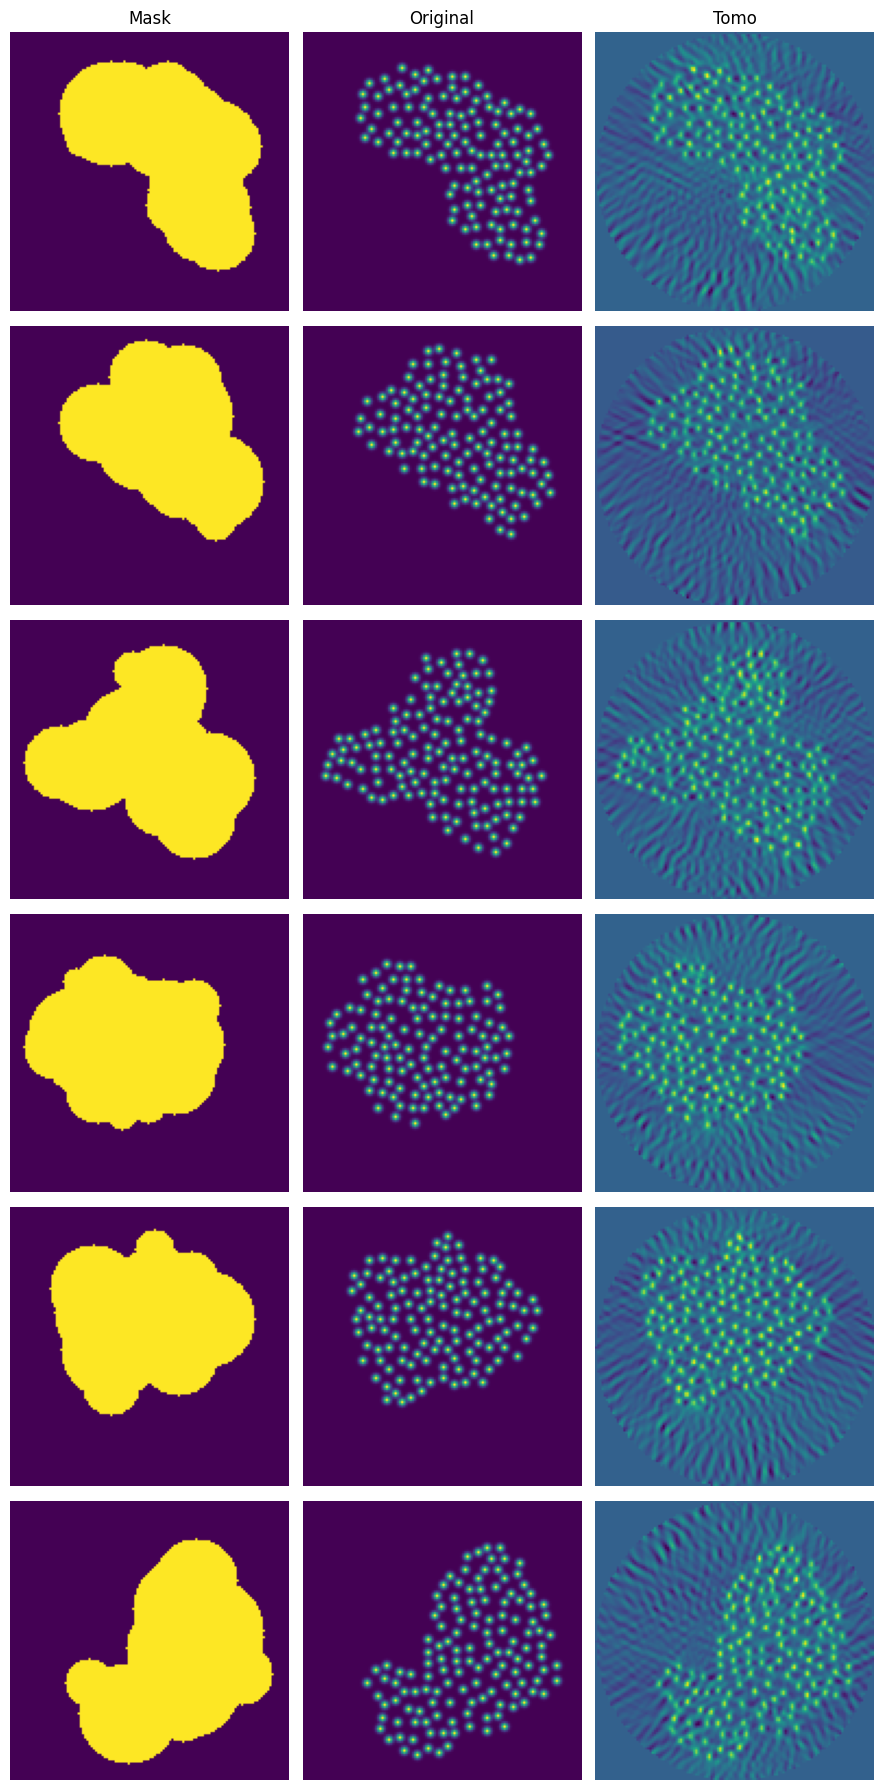

In [ ]:
idx = 0

fig, axes = plt.subplots(N, 3, figsize=(9, N * 3))

axes[0][0].set_title(f"Mask")
axes[0][1].set_title(f"Original")
axes[0][2].set_title(f"Tomo")

for idx in range(N):
    axes[idx][0].imshow(gt_masks[idx])
    axes[idx][1].imshow(gt_images[idx])
    axes[idx][2].imshow(data_images[idx])
    
for ax in axes.flatten():
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [ ]:
data_labels = ["train", "validation", "test"]
# num_data = [102400, 512, 64]
num_data = [1000, 200, 10]


data_root = "./data/"

In [ ]:
def worker(args):
    # args = (shape_cfg, atom_cfg, tomo_cfg, count)
    shape_cfg, atom_cfg, tomo_cfg, count, worker_idx = args
    pbar_kwargs = {
        "desc": f"Worker {worker_idx}",
        "position": worker_idx,
        "leave": True,
    }
    gt_imgs, gt_masks, gt_pos = create_data(
        shape_cfg, atom_cfg, count,
        display_progress=True,
        pbar_kwargs=pbar_kwargs
    )
    tomo_imgs = create_data_from_gt(
        gt_imgs, tomo_cfg,
        display_progress=True,
        pbar_kwargs=pbar_kwargs
    )
    return worker_idx, gt_imgs, gt_masks, tomo_imgs, gt_pos

def generate_and_save(label, count):
    n_procs = os.cpu_count() or 4
    print(f"{n_procs=}")
    # samples per proc
    chunk = count // n_procs
    
    counts = [chunk] * (n_procs - 1) + [count - chunk * (n_procs - 1)]
    args = [(shape_cfg, atom_cfg, tomo_cfg, cnt, idx) for idx, cnt in enumerate(counts)]
    
    with Pool(processes=n_procs) as pool:
        results = pool.map(worker, args)
    
    # merge
    results.sort(key=lambda x: x[0])
    gt_imgs   = np.concatenate([r[1] for r in results], axis=0)
    gt_masks  = np.concatenate([r[2] for r in results], axis=0)
    tomo_imgs = np.concatenate([r[3] for r in results], axis=0)
    gt_pos    = sum([r[4] for r in results], [])
    
    # save
    data_dir = os.path.join(data_root, label)
    os.makedirs(data_dir, exist_ok=True)
    np.save(os.path.join(data_dir, "gt_images.npy"), gt_imgs)
    np.save(os.path.join(data_dir, "gt_masks.npy"), gt_masks)
    np.save(os.path.join(data_dir, "tomo_images.npy"), tomo_imgs)
    np.save(os.path.join(data_dir, "gt_pos_list.npy"), np.array(gt_pos, dtype=object), allow_pickle=True)

In [ ]:
for label, num in zip(data_labels, num_data):
    generate_and_save(label, num)

n_procs=16


In [ ]:
for num, label in zip(num_data, data_labels):
    gt_images, gt_masks, gt_pos_list = create_data(
        shape_cfg,
        atom_cfg,
        num
    )
    tomo_images = create_data_from_gt(gt_images, tomo_cfg)
    
    data_dir = os.path.join(data_root, label)
    
    os.makedirs(data_dir, exist_ok=True)
    
    img_path = os.path.join(data_dir, "gt_images.npy")
    mask_path = os.path.join(data_dir, "gt_masks.npy")
    tomo_path = os.path.join(data_dir, "tomo_images.npy")
    pos_path = os.path.join(data_dir, "gt_pos_list.npy")
    
    np.save(img_path, gt_images)
    np.save(mask_path, gt_masks)
    np.save(tomo_path, tomo_images)
    np.save(pos_path, np.array(gt_pos_list, dtype=object), allow_pickle=True)
        

  0%|          | 104/102400 [00:54<17:34:47,  1.62it/s]